In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap
import numpy as np
from orphics import maps,io,stats,cosmology,lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
shape,wcs = maps.rect_geometry(width_deg=15.0,px_res_arcmin=1.5)
theory = cosmology.default_theory()
beam_arcmin = 1.5
noise_uk_arcmin = 7.0
flsims = lensing.FlatLensingSims(shape,wcs,theory,beam_arcmin,noise_uk_arcmin,noise_e_uk_arcmin=None,noise_b_uk_arcmin=None,pol=False,fixed_lens_kappa=None)

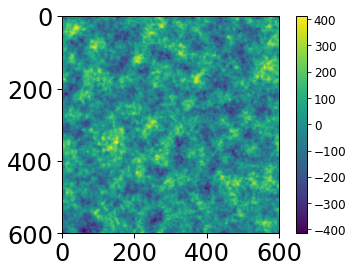

In [5]:
cmb = flsims.get_sim()
io.plot_img(cmb)

In [14]:
#n2d_beam_deconvolved = np.nan_to_num(flsims.ps_noise[0,0]/flsims.kbeam**2.)
n2d = np.nan_to_num(flsims.ps_noise[0,0])
tellmin = 300
tellmax = 3000
kellmin = 20
kellmax = 3500
tmask = maps.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)
kmask = maps.mask_kspace(shape,wcs,lmin=kellmin,lmax=kellmax)

qest = lensing.qest(shape,wcs,theory,noise2d=n2d,beam2d=flsims.kbeam,kmask=tmask,noise2d_P=None,kmask_P=None,kmask_K=kmask,pol=False,grad_cut=None,unlensed_equals_lensed=True,bigell=9000)

In [18]:
Nsims = 50
fc = maps.FourierCalc(shape,wcs)
nbins = 20
bin_edges = np.linspace(kellmin,kellmax,nbins)
binner = stats.bin2D(flsims.modlmap,bin_edges)

st = stats.Stats()

for i in range(Nsims):
    unlensed,kappa,lensed,beamed,noise_map,observed = flsims.get_sim(return_intermediate=True)
    recon = qest.kappa_from_map("TT",observed)
    pcross,_,_ = fc.power2d(recon,kappa)
    pii,_,_ = fc.power2d(kappa)
    cents,p1d = binner.bin(pcross)
    cents,pii1d = binner.bin(pii)
    st.add_to_stats("ratio",(p1d-pii1d)/pii1d)
    print(i)
st.get_stats()    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


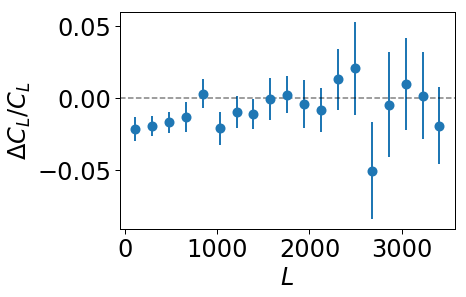

In [19]:
y = st.stats['ratio']['mean']
yerr = st.stats['ratio']['errmean']

pl = io.Plotter(xlabel='$L$',ylabel='$\Delta C_L/C_L$')
pl.add_err(cents,y,yerr=yerr,marker="o",ls="none",lw=2,elinewidth=2,mew=2,markersize=8)
pl.hline()
pl.done()